In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as ss
import gc
import copy
from PIL import Image
from matplotlib.pyplot import imshow
from sklearn.base import BaseEstimator, ClassifierMixin
from os import listdir, mkdir
from os.path import isfile, join
import math
from datetime import datetime
import time
from skimage.transform import radon
from skimage import color, data, restoration
from scipy import ndimage
from IPython.display import clear_output
# from method import momentum_method
import os.path

In [2]:
def FixImage(image):
    '''
    Returns image with values in [0, 1] segment
    for normal output with possible negative elements
    '''
    min_value = image.min()
    max_value = image.max()
    if min_value < 0:
        image -= min_value
    return image / (max_value - min_value)
        
def images_out(class_elem):
    '''
    Relatively normal output 
    of _cur_image and _init_image 
    in element of FunctionalMinimisation class
    '''
    plt.figure(figsize=(35,35))
    plt.subplot(1,2,1)
    plt.imshow(FixImage(class_elem._cur_image), cmap='gray')

    plt.subplot(1,2,2)
    plt.imshow(FixImage(class_elem._init_image), cmap='gray')

def save_img(class_elem, p='my_stuff.png', p_b='blurred.png'):
    plt.imsave(p, class_elem._cur_image, cmap='gray')
    plt.imsave(p_b, class_elem._init_image, cmap='gray')

DEBUG = True

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.299 * r + 0.5870 * g + 0.1140 * b
    return gray

def blend_images(orig, four, alpha = 0.8, colH = 10, w=1):
    orig_img = Image.open(orig).convert('RGBA')
    fourier_img = Image.open(four).convert('RGBA')
        
    orig_img = orig_img.resize(((fourier_img.size[0], fourier_img.size[1])), Image.BICUBIC)
    
    img = fourier_img
    A = img.getchannel('A')

    # Convert to HSV and save the V (Lightness) channel
    V = img.convert('RGB').convert('HSV').getchannel('V')

    # Synthesize new Hue and Saturation channels using values from colour picker
    colpickerH, colpickerS = colH, 255
    newH=Image.new('L',img.size,(colpickerH))
    newS=Image.new('L',img.size,(colpickerS))

    # Recombine original V channel plus 2 synthetic ones to a 3 channel HSV image
    HSV = Image.merge('HSV', (newH, newS, V))

    # Add original Alpha layer back in
    R,G,B = HSV.convert('RGB').split()
    RGBA = Image.merge('RGBA',(R,G,B,A))
    
    new_img = Image.blend(orig_img, RGBA, alpha)
    return new_img

def calculate_log(picture,threshold=0.5):
    log = np.log(np.abs(np.fft.fft2(Cepstrum.hamming(picture))))
    fourier_abs = np.abs(log)
    return fourier_abs

def wiener_filter(img, kernel, K=1):
    if np.shape(kernel)[0] == 0:
        return img
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = np.fft.fft2(dummy)
    kernel = np.fft.fft2(kernel, s = img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(np.fft.ifft2(dummy))
    return dummy

def get_blur_len(img, angle, weight, w=1):
    rotated_img = ndimage.rotate(img, -angle * 180/math.pi)
    rotated_img[rotated_img < 4/255 * rotated_img.max()] = 0
    r = radon(rotated_img, theta=[90], circle=False)
    r[r > 0.6 * r.max()] = 0
    r *= 1./max(r)
    blur_len = 0
    for i in range(len(r)):
        if (r[i] > 0.7):
            blur_len = len(r) // 2 - 1 - i 
#             if (blur_len > 2 * img.shape[0] // 5):
#                 blur_len = 0
            break
    
    if (DEBUG):
        h = img.shape[0]
        q = h // 2 - 1
        k = -math.tan(angle)
        b = (1 - k) * q
        l = []
        if abs(abs(angle * 180/math.pi) - 90) > 10:
            for old_x in range(q - blur_len, q + blur_len):
                old_y = round(k * old_x+b)
                old_y = int((old_y if old_y >= 0 else 0) if old_y <= h-1 else h-1)
                if (old_y <= 1 or old_y >= h-2 or old_x <= 1 or old_x >= h-2):
                    continue
                for i in range(-w, w+1):
                    for j in range(-w, w+1):
                        x = old_x
                        y = old_y
                        y += i
                        y = (y if y >= 0 else 0) if y <= h-1 else h-1
                        x += j
                        x = (x if x >= 0 else 0) if x <= h-1 else h-1
                        if (y, x) not in l:
                            l.append((y, x))
        else:
            for y in range(q - blur_len, q + blur_len):
                for i in range(-w, w+1):
                    if (y, q + i) not in l:
                        l.append((y, q + i))
        p = np.zeros((h, h))
        for t in l:
            p[t] = weight
        return (int(abs(blur_len)), p)
    else:
        return int(abs(blur_len))

def find_best_line(template_picture, dif=180):
    h = template_picture.shape[0]
    q = h // 2 - 1
    theta = np.linspace(0., 180, dif, endpoint=False)
    sinogram = radon(template_picture, theta=theta, circle=True)
    max_values = sinogram.max(axis=0)
    if DEBUG:
        tmp.append(sinogram)
    return (max(max_values), theta[np.argmax(max_values)] * math.pi/180 - math.pi/2)

def make_ker(ker_len, ker_angle):
#     h = ker_len * 2
    h = ker_len
    ker_len = ker_len // 2
    ker = np.zeros((h, h), dtype='float')
    
    k = -math.tan(ker_angle)
    b = (1 - k) * ker_len
    if abs(abs(ker_angle * 180/math.pi) - 90) > 10:
        for x in range(h):
            y = round(k * x + b)
            y = int((y if y >= 0 else 0) if y <= h-1 else h-1)
            if (y == 0 or y == h - 1):
                continue
            ker[y, x] = 1
    else:
        for y in range(h):
            ker[y, ker_len] = 1 
    ret_value = ker/ker.sum()
    if np.isnan(np.sum(ret_value)):
        return []
    else:
        return ret_value

def get_common_ker_len_angle(kers):
    max_shape = max([a[0] for a in kers])
    lenghts = [a[0] for a in kers]
    angles =  [a[1] for a in kers]
    
    return (int(np.mean(lenghts)), np.mean(angles))

class Cepstrum:
    def __init__(self, picture, batch_size=64, step=0.25):
        gc.enable()
        self.batch_size = batch_size
        self.step = step
        self.x_batches = int(picture.shape[1] // (batch_size * step) - 1)
        self.y_batches = int(picture.shape[0] // (batch_size * step) - 1)
        self.picture = copy.deepcopy(picture)
        self.squared_image = [0] * self.x_batches * self.y_batches
        self.MainProcess()
        plt.imsave('orig_img.png', self.picture, cmap='gray')

    def get_square(self):
        pixel_step = int(self.batch_size * self.step)
        for y in range(self.y_batches):
            for x in range(self.x_batches):
                square = self.picture[y * pixel_step : y * pixel_step + self.batch_size,
                                   x * pixel_step : x * pixel_step + self.batch_size]
                self.squared_image[y * self.x_batches + x] = square
                yield self.swap_quarters(Cepstrum.calculate_cepstrum(square))

    def ft_array(self):
        # CALCULATE CEPSTRUMS
        
        t = time.time()
            
        self.count_ft()
        if (DEBUG):
            print("Counted cepstrums: ", time.time() - t)
        self.count_angles()
        if (DEBUG):
            print("Counted angles: ", time.time() - t)
        self.count_lengths()
        if (DEBUG):
            print("Counted lengths: ", time.time() - t)
        self.make_kernels()
        if (DEBUG):
            print("Counted kernels: ", time.time() - t)
        
        self.weight = self.weight.reshape((self.y_batches, self.x_batches))
        self.weight /= self.weight.max()
        self.angle = self.angle.reshape((self.y_batches, self.x_batches))
        self.blur_len = self.blur_len.reshape((self.y_batches, self.x_batches))
        if (np.max(self.blur_len) == 0) :
            self.angle_value = 0
            print("Unable to calculate blur lengths")
            return
        # self.kernels = np.reshape(self.kernels, (self.y_batches, self.x_batches, 2)) #here
        self.blur_len_value, self.angle_value = get_common_ker_len_angle(self.kernels)
        self.kernel_image = make_ker(self.blur_len_value, self.angle_value)
        self.squared_image = np.reshape(self.squared_image, (self.y_batches, self.x_batches, self.batch_size, self.batch_size))
        # self.restore1() 
#         self.restore() #here
        
    def MainProcess(self):
        self.ft_array()
        try:
            temp2 =[ 0 ] * self.y_squares
            for y in range(self.y_squares):
                temp2[y] = np.hstack(self.restored_image[y, :, :, :])
            self.restored_image_full = np.vstack(temp2)
        except AttributeError as error:
            return
            
    def hamming(picture):
        hm_len = picture.shape[0]
        bw2d = np.outer(ss.hamming(hm_len), np.ones(hm_len))
        bw2d = bw2d * bw2d.T
        return picture * bw2d
    
    def calculate_cepstrum(picture,threshold=0.5):
        log = np.log(1 + np.abs(np.fft.fft2(Cepstrum.hamming(picture))))
        fourier_abs = np.abs(np.fft.ifft2(log))
        fourier_abs[fourier_abs >= threshold * fourier_abs.max()] = 0
        fourier_abs[fourier_abs >= threshold * fourier_abs.max()] = 0
        
        return fourier_abs
    
    def swap_quarters(self, picture):
        out_pict = copy.deepcopy(picture)
        batch_size = picture.shape[0]
        temp_pict = copy.deepcopy(out_pict[: batch_size//2, : batch_size//2])
        out_pict[: batch_size//2, : batch_size//2] = out_pict[batch_size//2 :, batch_size//2 :]
        out_pict[batch_size//2 :, batch_size//2 :] = temp_pict
        temp_pict = copy.deepcopy(out_pict[: batch_size//2, batch_size//2 :])
        out_pict[: batch_size//2, batch_size//2 :] = out_pict[batch_size//2 :, : batch_size//2]
        out_pict[batch_size//2 :, : batch_size//2] = temp_pict[:]
        return out_pict
    
    def restore(self):
        self.cut_image = []
        pixel_step = self.batch_size
        self.y_squares = int(self.picture.shape[0] // self.batch_size)
        self.x_squares = int(self.picture.shape[1] // self.batch_size)
        for y in range(self.y_squares):
            for x in range(self.x_squares):
                square = self.picture[y * pixel_step : y * pixel_step + self.batch_size,
                                   x * pixel_step : x * pixel_step + self.batch_size]
                self.cut_image.append(square)
        self.cut_image = np.reshape(self.cut_image, (self.y_squares, self.x_squares, pixel_step, pixel_step))
        self.restored_image = np.copy(self.cut_image)

        ker_divider = int(1. / self.step)
        self.new_kernels = [[0] * self.x_squares] * self.y_squares
        
        def tf(y, x):
            new_y = int((y if y >= 0 else 0) if y <= self.y_batches - 1 else self.y_batches - 1)
            new_x = int((x if x >= 0 else 0) if x <= self.x_batches - 1 else self.x_batches - 1)
            return (new_y, new_x)
        
        for y_orig in range(self.y_squares):
            for x_orig in range(self.x_squares):
                k_l = []
                for y in range(-ker_divider + 1, ker_divider):
                    for x in range(-ker_divider + 1, ker_divider):
                        k_l.append(self.kernels[tf(y_orig * ker_divider + y, x_orig * ker_divider + x)])
                
                self.new_kernels[y_orig][x_orig] = make_ker(get_common_ker_len_angle(k_l))
                print(y_orig, x_orig)
                self.restored_image[y_orig, x_orig] =\
                    self.restore_function(self.cut_image[y_orig, x_orig], self.new_kernels[y_orig][x_orig])
        return self.restored_image
    
    def restore1(self):
        self.deb_ker = make_common_ker(self.kernels)
        plt.imsave(save_dir + filename[:-4] + '_ker_'+ str(c.batch_size) +'.png', self.deb_ker, cmap='gray')
        self.restored_image_full = self.restore_function(self.picture, self.deb_ker)
    
    def count_ft(self):
        self.cepstrum_picture = np.array(list(self.get_square()))
            
        self.conc_cepstrum_picture = self.cepstrum_picture.reshape((self.y_batches, self.x_batches, self.batch_size, self.batch_size))
        temp  = [ 0 ] * self.y_batches
        for y in range(self.y_batches):
            temp[y] = np.hstack(self.conc_cepstrum_picture[y, :, :, :])
        self.conc_cepstrum_picture = np.vstack(temp)
        plt.imsave('big_img.png', self.conc_cepstrum_picture, cmap='gray')
    
    def count_angles(self):
        self.weight = np.ndarray((self.y_batches * self.x_batches), dtype='float')
        self.angle = np.ndarray((self.y_batches * self.x_batches), dtype='float')
        if (DEBUG):
            self.lines_img = np.copy(self.cepstrum_picture)
        for idx, q in enumerate(self.cepstrum_picture):
            self.weight[idx], self.angle[idx] = find_best_line(q)
                
    def count_lengths(self):
        self.blur_len = np.ndarray((self.y_batches * self.x_batches), dtype='int')
        for idx, q in enumerate(self.cepstrum_picture):
            if (DEBUG): 
                self.blur_len[idx], self.lines_img[idx] = get_blur_len(q, self.angle[idx], self.weight[idx])
                self.conc_lines_img = self.lines_img.reshape((self.y_batches, self.x_batches, self.batch_size, self.batch_size))
                temp  = [ 0 ] * self.y_batches
                for y in range(self.y_batches):
                    temp[y] = np.hstack(self.conc_lines_img[y, :, :, :])
                self.conc_lines_img = np.vstack(temp)
                plt.imsave('lines_img.png', self.conc_lines_img, cmap='gray')
            else:
                self.blur_len[idx] = get_blur_len(q, self.angle[idx], self.weight[idx])
            
    def make_kernels(self):
        self.kernels = [0] * self.y_batches * self.x_batches
        for idx, q in enumerate(self.cepstrum_picture):
            self.kernels[idx] = (self.blur_len[idx], self.angle[idx])
            
    def restore_function(self, img, kernel):
#         img /= img.max()
#         if (np.shape(kernel)[0] == 0):
#             return img
#         self.z_0 = np.zeros(img.shape)
#         return momentum_method(self.z_0, 0.85, kernel, img)
#         return wiener_filter(img, kernel)    
        # betas = [0.01/math.sqrt(i) for i in range(1, 60)]
        # self.minimis = FunctionalMinimisation(img, kernel, betas)
        # self.minimis.MainProcess()
        # return self.minimis._cur_image
        pass

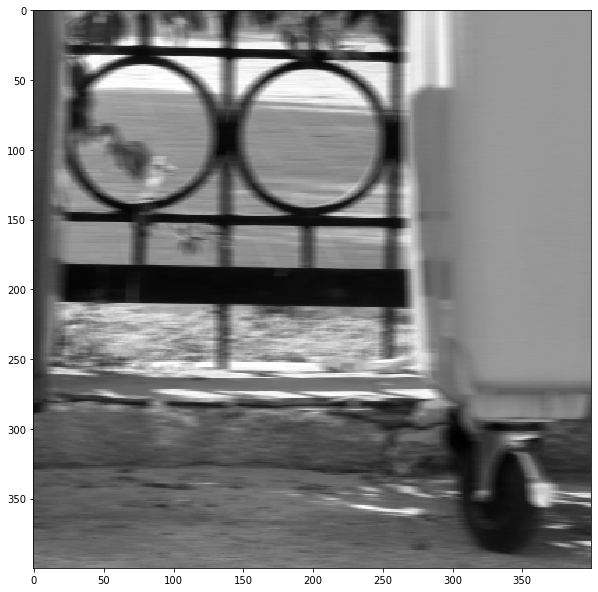

In [4]:
work_dir = "./pict/"
save_dir = './result/'
filename = "test.png"

img = rgb2gray(plt.imread(os.path.join(work_dir, filename)))

plt.figure(figsize=(10,230))
plt.imshow(img, cmap='gray')

In [24]:
DEBUG = False
tmp = []


# c = Cepstrum(img, batch_size=128, step=0.5)

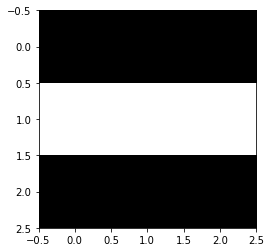

In [29]:
plt.imshow(c.kernel_image, cmap='gray')

In [4]:
get_common_ker_len_angle(c.kernels)

NameError: name 'c' is not defined

In [25]:
dir_x = './pict/b_test/'
fnames_X = listdir(dir_x)
dir_y = './pict/s_test/'
fnames_y = listdir(dir_y)
X = list([dir_x + item for item in fnames_X])[:30]
y = list([dir_y + item for item in fnames_y])[:30]

save_dir_x = './pict/b_test_rotated/'
save_dir_y = './pict/s_test_rotated/'

In [26]:
from scipy import ndimage

In [27]:
%time
global_angles = []
for idx, p in enumerate(X):
    # p = X[15]
    img = plt.imread(p)
    orig_img = plt.imread(y[idx])
    wb_img = rgb2gray(img)
    c = Cepstrum(wb_img, batch_size=256, step=0.5)
    rotated_img = ndimage.rotate(img, - c.angle_value * 60)
    orig_rotated_img = ndimage.rotate(orig_img, - c.angle_value * 60)
    # plt.imshow(rotated_img)
    if (idx % 10 == 0):
        print('Angle: ' + str(c.angle_value))
    global_angles.append(c.angle_value)
    plt.imsave(save_dir_x + fnames_X[idx], np.clip(rotated_img, 0., 1.))
    plt.imsave(save_dir_y + fnames_y[idx], np.clip(orig_rotated_img, 0., 1.))
    # break

Wall time: 0 ns
Angle: -1.1737339219661866
C:\Users\Admin\anaconda3\lib\site-packages\ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in true_divide
Angle: 0.06981317007977328
Angle: 0.00436332312998583


In [4]:
import pickle

In [22]:
with open('./pict/angles.pkl', 'wb') as output:
    pickle.dump(global_angles, output, pickle.HIGHEST_PROTOCOL)

In [5]:
with open('./pict/angles.pkl', 'rb') as f:
    global_angles = pickle.load(f)

In [10]:
dir_x = '../Diploma/result/b_test_rotated/'
fnames_X = listdir(dir_x)
X = list([dir_x + item for item in fnames_X])
save_dir_x = '../Diploma/result/b_test_back_rotated/'

In [19]:
%time
for idx, p in enumerate(X):
    # p = X[15]
    img = plt.imread(p)
    rotated_img = ndimage.rotate(img, global_angles[idx] * 60)
    edge = (rotated_img.shape[0] - 600) // 2 + 1
    # print(rotated_img.shape, edge)
    # plt.imshow(rotated_img)
    plt.imsave(save_dir_x + fnames_X[idx], np.clip(rotated_img[edge:edge + 600, edge:edge + 600], 0., 1.))

Wall time: 0 ns
